In [4]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [5]:
%load_ext autoreload
%autoreload 2

import os
os.chdir('..')

In [110]:
from src.experiments import Fusion_MVAE_Experiment, Celeba_MVAE_Experiment
import torch
from nflows.utils import torchutils
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import torch.nn.functional as F
import cv2
import numpy as np
from src.datamodules.celeba import CelebaDataset
from src.viz import plot_tsne, plot_pca
import pandas as pd
import seaborn as sns

# Loading Model

In [75]:
jmvae_ckpt_path = 'checkpoints/vae-expt-v4/jmvae_0/last.ckpt'
jmvae_flow_ckpt_path = 'checkpoints/vae-expt-v4/jmvae_postflow_2/last.ckpt'

mvae_ckpt_path = 'checkpoints/vae-expt-v4/mvae_3/last.ckpt'
mvae_flow_ckpt_path = 'checkpoints/vae-expt-v4/mvae_postflow_1/last.ckpt'

celeba_ckpt_path = 'checkpoints/vae-celeba/vaevae_1/last.ckpt'
celeba_flow_ckpt_path = 'checkpoints/vae-celeba/vaevae_priorflow_3/last.ckpt'

In [11]:
jmvae = Fusion_MVAE_Experiment.load_from_checkpoint(
    checkpoint_path=jmvae_ckpt_path,
    strict=False
)
jmave.eval();

Using downloaded and verified file: data/train_32x32.mat
Using downloaded and verified file: data/test_32x32.mat


In [12]:
jmvae_flow = Fusion_MVAE_Experiment.load_from_checkpoint(
    checkpoint_path=jmvae_flow_ckpt_path,
    strict=False
)
jmave_flow.eval();

Using downloaded and verified file: data/train_32x32.mat
Using downloaded and verified file: data/test_32x32.mat


In [77]:
mvae = Fusion_MVAE_Experiment.load_from_checkpoint(
    checkpoint_path=mvae_ckpt_path,
    strict=False
)
mvae.eval();

Using downloaded and verified file: data/train_32x32.mat
Using downloaded and verified file: data/test_32x32.mat


In [78]:
mvae_flow = Fusion_MVAE_Experiment.load_from_checkpoint(
    checkpoint_path=mvae_flow_ckpt_path,
    strict=False
)
mvae_flow.eval();

Using downloaded and verified file: data/train_32x32.mat
Using downloaded and verified file: data/test_32x32.mat


In [137]:
celeba = Celeba_MVAE_Experiment.load_from_checkpoint(
    checkpoint_path=celeba_ckpt_path,
    strict=False
)

In [138]:
celeba_flow = Celeba_MVAE_Experiment.load_from_checkpoint(
    checkpoint_path=celeba_flow_ckpt_path,
    strict=False
)

# Get Dataset Samples

In [16]:
dl = expt.datamodule.train_dataloader()

In [17]:
batch = next(iter(dl))
mnist, svhn = batch['data']

In [18]:
mnist.shape, svhn.shape

(torch.Size([256, 1, 28, 28]), torch.Size([256, 3, 32, 32]))

In [25]:
grid = make_grid(svhn[:64], nrow=8)
grid = grid.permute(1, 2, 0).cpu().numpy()

In [30]:
grid = cv2.resize(grid, dsize=(242, 242))

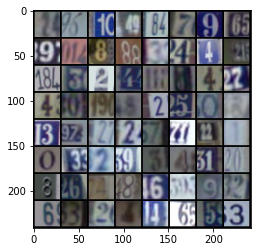

In [31]:
plt.imshow(grid)

In [32]:
grid.shape

(242, 242, 3)

In [33]:
plt.imsave('saved/test.png', grid)

In [139]:
dl = celeba.datamodule.train_dataloader()

In [140]:
batch = next(iter(dl))
img, text = batch['data']

In [142]:
grid = make_grid(img[:64], nrow=8)
grid = grid.permute(1, 2, 0).cpu().numpy()

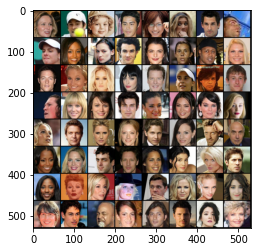

In [143]:
plt.imshow(grid)

In [144]:
plt.imsave('saved/test.png', grid)

# Cross-Generation

In [30]:
celeba_ds = CelebaDataset('data')

In [171]:
texts = torch.zeros(5, 256, 71)

In [172]:
for i in range(5):
    _, text = celeba_ds[i]['data']
    texts[i] = text


In [145]:
inputs = [img[:5], text[:5]]

In [146]:
img_recons, text_recons = celeba.model.cross_reconstruct(
    inputs, num_samples=8, mean=True
)

In [114]:
mnist_recons = mnist_recons.view(-1, 1, 28, 28)
svhn_recons = svhn_recons.view(-1, 3, 32, 32)

In [124]:
recons_grid = make_grid(svhn_recons, nrow=7)
recons_grid = recons_grid.permute(1, 2, 0).cpu().detach().numpy()

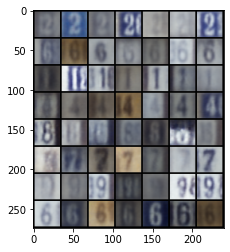

In [125]:
plt.imshow(recons_grid)

In [95]:
recons_grid.shape

(274, 240, 3)

In [126]:
recons_grid = cv2.resize(recons_grid, dsize=(212, 242))

In [127]:
samples_grid = make_grid(mnist[:8], nrow=1)
samples_grid = samples_grid.permute(1, 2, 0).cpu().numpy()

In [128]:
samples_grid = cv2.resize(samples_grid, dsize=(30, 242))

In [80]:
samples_grid.shape

(242, 30, 3)

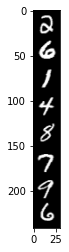

In [129]:
plt.imshow(samples_grid)

In [130]:
grid = np.hstack([samples_grid, recons_grid])

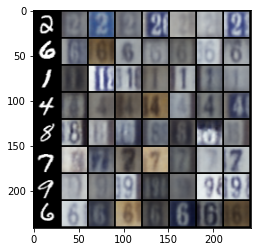

In [131]:
plt.imshow(grid)

In [132]:
plt.imsave('saved/test.png', grid)

### CelebA

In [174]:
inputs = inputs = [img[:5], texts]

In [179]:
img_recons, text_recons = celeba_flow.model.cross_reconstruct(
    inputs, num_samples=8, mean=True
)

In [180]:
img_recons = img_recons.view(-1, 3, 64, 64)

In [181]:
recons_grid = make_grid(img_recons, nrow=8)
recons_grid = recons_grid.permute(1, 2, 0).cpu().detach().numpy()

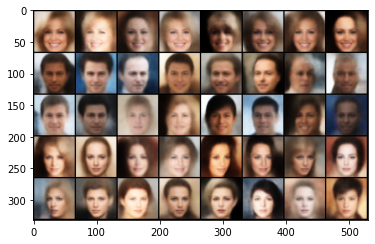

In [182]:
plt.imshow(recons_grid)

In [188]:
plt.imsave('saved/test.png', recons_grid)

In [192]:
celeba.datamodule.train_set.get_text_str(4)

'**************************************************************************************************************arched eyebrows, attractive, big lips, heavy makeup, narrow eyes, no beard, pointy nose, wearing lipstick, young**********************************'

# T-SNE

In [104]:
dl = jmvae.datamodule.train_dataloader()

### Load Data

In [105]:
N = 20
mnists = []
svhns = []
classes = []

counter = 0
for batch in dl:
    mnist, svhn = batch['data']
    mnists.append(mnist)
    svhns.append(svhn)

    classes.append(batch['label'])

    counter += 1
    if counter == N:
        break

mnists = torch.cat(mnists)
svhns = torch.cat(svhns)
classes = torch.cat(classes)

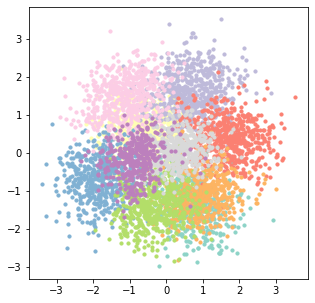

In [106]:
z_loc = jmvae.model.encode([mnists, svhns])
fig = plot_pca(z_loc, classes)

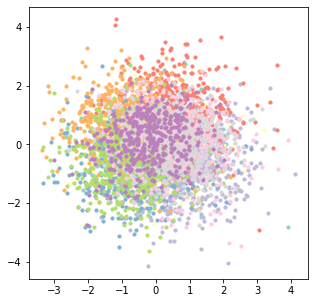

In [107]:
z_loc = jmvae_flow.model.encode([mnists, svhns])
fig = plot_pca(z_loc, classes)

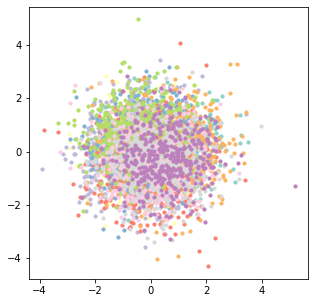

In [108]:
z_loc = mvae_flow.model.encode([mnists, svhns])
fig = plot_pca(z_loc, classes)

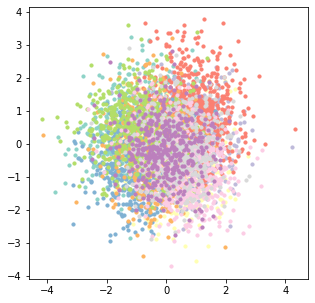

In [109]:
z_loc = mvae.model.encode([mnists, svhns])
fig = plot_pca(z_loc, classes)

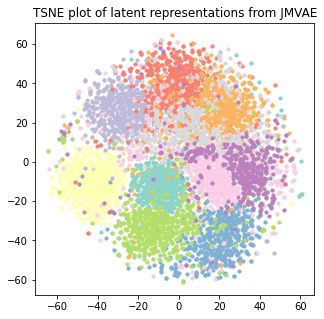

In [87]:
z_loc = jmvae.model.encode([mnists, svhns])
fig = plot_tsne(z_loc, classes, title="TSNE plot of latent representations from JMVAE")

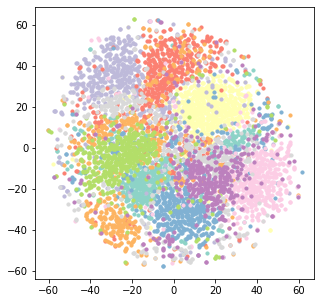

In [95]:
z_loc = jmvae_flow.model.encode([mnists, svhns])
fig = plot_tsne(z_loc, classes)

In [ ]:
fig.savefig('saved/test.png')

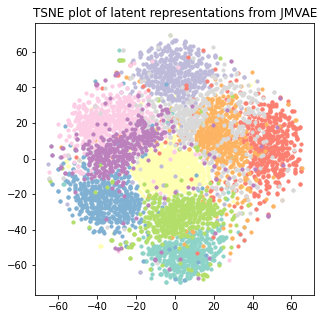

In [89]:
z_loc = mvae.model.encode([mnists, svhns])
fig = plot_tsne(z_loc, classes, title="TSNE plot of latent representations from JMVAE")

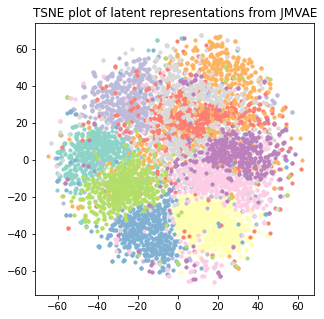

In [90]:
z_loc = mvae_flow.model.encode([mnists, svhns])
fig = plot_tsne(z_loc, classes, title="TSNE plot of latent representations from JMVAE")

# Plots

In [114]:
data = pd.read_csv('saved/mnist_svhn/results.csv')

In [115]:
data

model  m_latent  s_latent  m_s_latent  joint_coherence  m_s_coherence  \
0  JMVAE     96.43     64.85       96.44            55.81          82.04   
1  JMVAE     96.59     93.62       96.63            59.89          86.16   
2   MVAE     95.45     46.91       95.57            40.85          61.79   
3   MVAE     96.35     53.76       96.40            52.38          74.26   
4  MMVAE     95.07     42.54       95.07            37.75          58.41   
5  MMVAE     96.50     53.20       96.20            50.26          72.43   

   s_m_coherence   flow  
0          61.92  False  
1          93.99   True  
2          42.24  False  
3          50.60   True  
4          40.44  False  
5          49.45   True

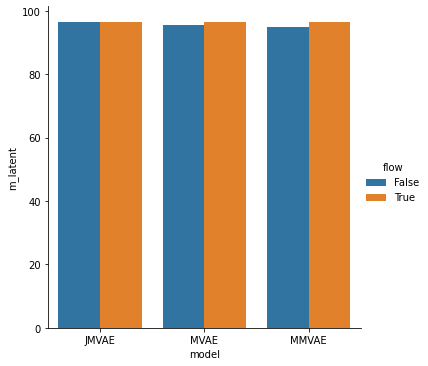

In [116]:
sns.catplot(x='model', y='m_latent', hue='flow', kind='bar', data=data)

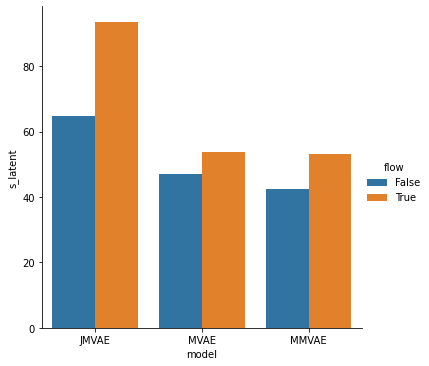

In [117]:
sns.catplot(x='model', y='s_latent', hue='flow', kind='bar', data=data)

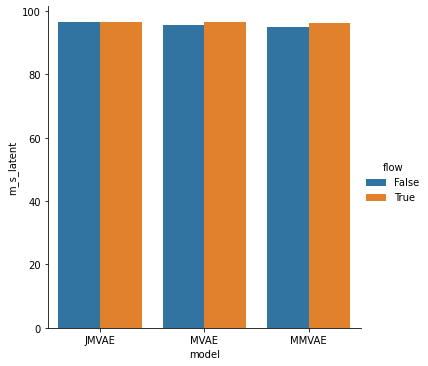

In [118]:
sns.catplot(x='model', y='m_s_latent', hue='flow', kind='bar', data=data)

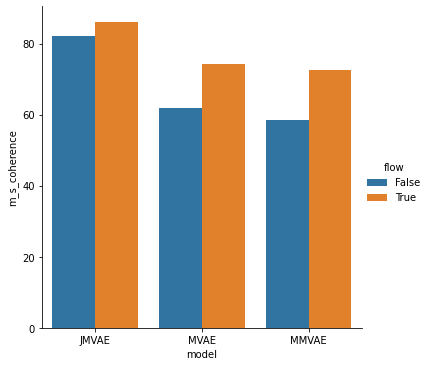

In [120]:
sns.catplot(x='model', y='m_s_coherence', hue='flow', kind='bar', data=data)

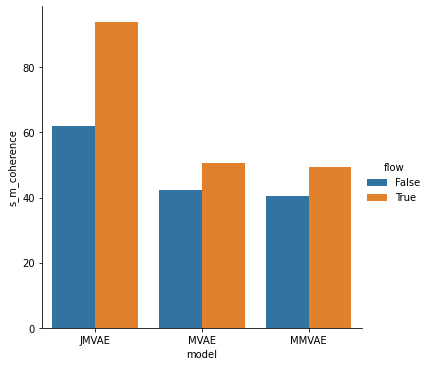

In [121]:
sns.catplot(x='model', y='s_m_coherence', hue='flow', kind='bar', data=data)